# Online Retail Transactional Data Machine Learning

In [3]:
import numpy as np
import pandas as pd
import os
import time

from datetime import datetime, date, time, timedelta, timezone, tzinfo 
import pytz

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mlxtend.plotting import scatterplotmatrix, heatmap

from sklearn import datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier, XGBRFRegressor

import pandasql as sql

from wordcloud import WordCloud, STOPWORDS

print(pd.__version__)
pd.set_option('display.width', 160)  # default is 80
#pd.set_option('display.max_colwidth', 30)


pd.options.display.float_format = "{:,.2f}".format
#pd.options.display.float_format = "{:,.3g}".format
pd.set_option('max_columns', None)  # print all the columns
# pd.reset_option('max_columns') # go back to the default value
pd.set_option('display.max_columns', None)


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # default value is: 'last_expr'

# suppress scientific notion in ndarrays
np.set_printoptions(suppress=True,   formatter={
                    'float_kind': '{:0.2f}'.format})

1.0.5


## Data Description

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The data in the workbook are organized as a range in the Online Retail spreadsheet.  Each record represents a line item in a sales transaction. The fields included in the dataset are:

| Field | Description |
|-------------:|-----:|
|InvoiceNo|A 6-digit integral number uniquely assigned to each transaction|
|StockCode|A 5-digit integral number uniquely assigned to each distinct product|
|Description|The product (item) name|
|Quantity|The quantities of each product (item) per transaction|
|InvoiceDate|The invoice date and a time in mm/dd/yy hh:mm format|
|UnitPrice|The per-unit product price in pound sterling (£)|
|CustomerID| A 5-digit integral number uniquely assigned to each customer|
|Country|The name of the country where each customer resides|

Of these fields, the ones of particular interest for our work are InvoiceNo which identifies the transaction, InvoiceDate which identifies the date of that transaction, and CustomerID which uniquely identifies the customer across multiple transactions. (In a separate notebook, we will examine the monetary value of the transactions through the UnitPrice and Quantity fields.)

## Import Data

In [4]:
date_cols = ['InvoiceDate']
#df=pd.read_excel("Online Retail.xlsx", engine='openpyxl')
df=pd.read_csv("C:\\0delete\Online Retail.csv", encoding = 'unicode_escape', parse_dates=date_cols)
df['SalesAmount'] = df['Quantity'] * df['UnitPrice']

df['StockClass']=df['StockCode'].apply(lambda x: x[0:3])

df['year']=df['InvoiceDate'].dt.year
df['month']=df['InvoiceDate'].dt.month
df['date']=df['InvoiceDate'].dt.date
df['yrmo_period']=df['InvoiceDate'].dt.to_period('M')
df['date_period']=df['InvoiceDate'].dt.to_period('D')

df.isnull().sum()
df.info()
df.describe().T
df.shape
df.head(5)


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
SalesAmount         0
StockClass          0
year                0
month               0
date                0
yrmo_period         0
date_period         0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   SalesAmount  541909 non-null  float64       
 9   StockClass   541909 non-null  object        
 10  year         541909 non-null  int64         
 11  month        541909 non-null  int64         
 12  date         541909 non-null  object        
 13  yrmo_period  541909 non-null  period[M]     
 14  date_period  541909 non-null  period[D]     
dtypes: datetime64[ns](1), float64(3), 

,count,mean,std,min,25%,50%,75%,max
Quantity,"541,909.00",9.55,218.08,"-80,995.00",1.00,3.00,10.00,"80,995.00"
UnitPrice,"541,909.00",4.61,96.76,"-11,062.06",1.25,2.08,4.13,"38,970.00"
CustomerID,"406,829.00","15,287.69","1,713.60","12,346.00","13,953.00","15,152.00","16,791.00","18,287.00"
SalesAmount,"541,909.00",17.99,378.81,"-168,469.60",3.40,9.75,17.40,"168,469.60"
year,"541,909.00","2,010.92",0.27,"2,010.00","2,011.00","2,011.00","2,011.00","2,011.00"
month,"541,909.00",7.55,3.51,1.00,5.00,8.00,11.00,12.00


(541909, 15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SalesAmount,StockClass,year,month,date,yrmo_period,date_period
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom,15.30,851,2010,12,2010-12-01,2010-12,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34,710,2010,12,2010-12-01,2010-12,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom,22.00,844,2010,12,2010-12-01,2010-12,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34,840,2010,12,2010-12-01,2010-12,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34,840,2010,12,2010-12-01,2010-12,2010-12-01


In [3]:
sql.sqldf("select count(*)\
, count(distinct invoiceno) \
, count(distinct stockcode)\
, count(distinct description)\
, count(distinct customerid)\
from df")

,count(*),count(distinct invoiceno),count(distinct stockcode),count(distinct description),count(distinct customerid)
0,541909,25900,4070,4223,4372


In [4]:
sql.sqldf("select count(*)\
, count(distinct invoiceno) \
, count(distinct stockcode)\
, count(distinct description)\
, count(distinct customerid)\
from df where customerid is not null")

,count(*),count(distinct invoiceno),count(distinct stockcode),count(distinct description),count(distinct customerid)
0,406829,22190,3684,3896,4372


## Exploratory and Descriptive Analysis

<Figure size 1080x576 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, '# of Transactions')

Text(0.5, 1.0, '# of Transactions by Date')

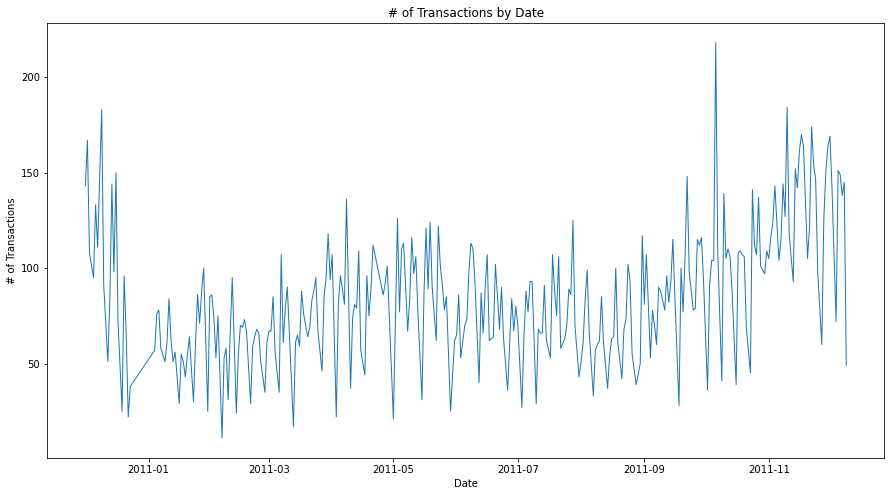

In [5]:
df2=df.assign(Invoice_Date=df['InvoiceDate'].dt.date).groupby(['Invoice_Date'])['InvoiceNo'].nunique().to_frame()

plt.figure(figsize=(15,8))
plt.plot(df2.index, df2['InvoiceNo'], linewidth=1)
plt.xlabel('Date')
plt.ylabel('# of Transactions')
plt.title('# of Transactions by Date')

<AxesSubplot:xlabel='Invoice_Date', ylabel='cancel_ind'>

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Cancellation %')

Text(0.5, 1.0, 'Cancellation Percentage by Month')

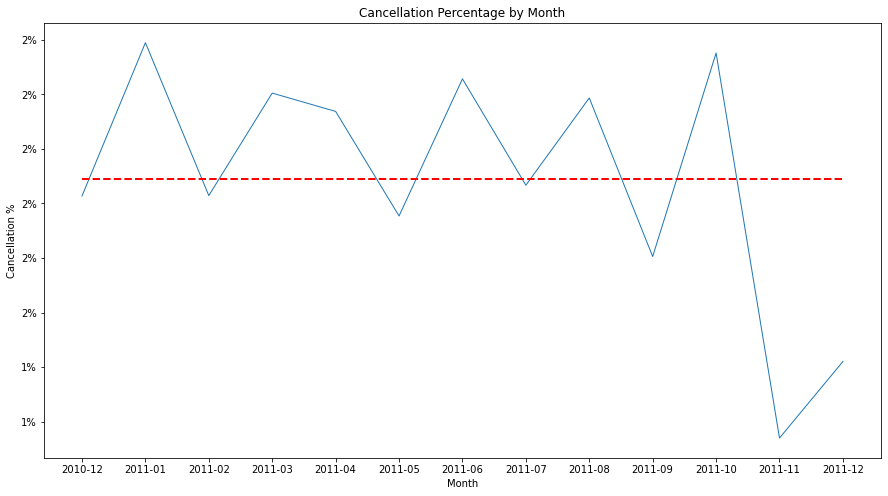

In [26]:
df2=df.copy()
df2['cancel_ind']=np.where(df2['InvoiceNo'].str.startswith("C", na=False), 1, 0)
df2=df2.assign(Invoice_Date=df2['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m')) ).groupby(['Invoice_Date'])['cancel_ind'].mean().to_frame().reset_index()

from matplotlib.ticker import FuncFormatter

fig, ax=plt.subplots(figsize=(15,8))
sns.lineplot(x='Invoice_Date', y='cancel_ind', data=df2, linewidth=1)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_xlabel('Month')
ax.set_ylabel('Cancellation %')
ax.set_title('Cancellation Percentage by Month')
ax.hlines(y=np.mean(df2['cancel_ind']), xmin=min(df2.index), xmax=max(df2.index), linewidth=2, color='r',linestyles='--')


<Figure size 1080x576 with 0 Axes>

(array([1313.00, 817.00, 490.00, 377.00, 0.00, 288.00, 196.00, 157.00,
        117.00, 0.00, 80.00, 78.00, 62.00, 0.00, 51.00, 38.00, 41.00,
        28.00, 0.00, 26.00, 19.00, 22.00, 0.00, 16.00, 14.00, 10.00, 13.00,
        0.00, 9.00, 6.00, 4.00, 0.00, 7.00, 12.00, 5.00, 9.00, 0.00, 3.00,
        8.00, 1.00, 0.00, 2.00, 3.00, 5.00, 2.00, 0.00, 0.00, 1.00, 3.00,
        1.00]),
 array([1.00, 1.78, 2.56, 3.34, 4.12, 4.90, 5.68, 6.46, 7.24, 8.02, 8.80,
        9.58, 10.36, 11.14, 11.92, 12.70, 13.48, 14.26, 15.04, 15.82,
        16.60, 17.38, 18.16, 18.94, 19.72, 20.50, 21.28, 22.06, 22.84,
        23.62, 24.40, 25.18, 25.96, 26.74, 27.52, 28.30, 29.08, 29.86,
        30.64, 31.42, 32.20, 32.98, 33.76, 34.54, 35.32, 36.10, 36.88,
        37.66, 38.44, 39.22, 40.00]),
 <BarContainer object of 50 artists>)

Text(0.5, 0, '# of Transactions')

Text(0, 0.5, 'Count of Customers')

Text(0.5, 1.0, 'The Distribution of # of Transactions per Customer')

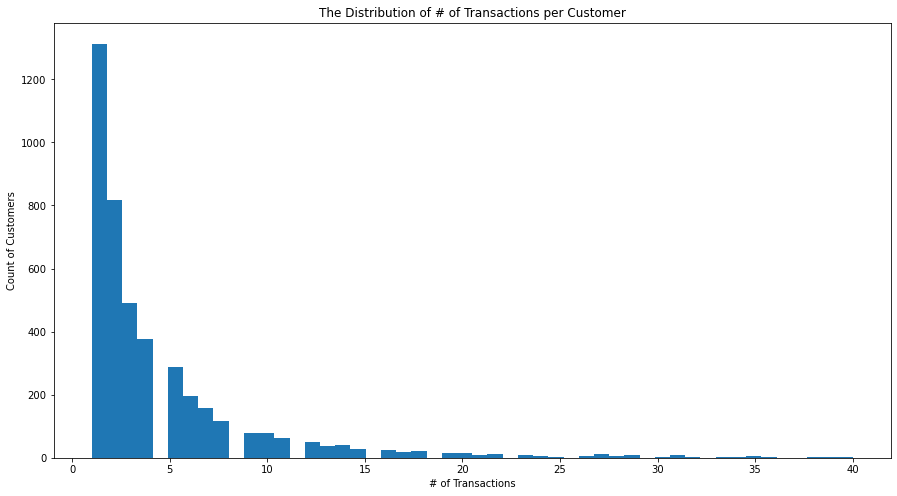

In [15]:
df2=df.assign(Invoice_Date=df['InvoiceDate'].dt.date).groupby(['CustomerID'])['InvoiceNo'].nunique().to_frame()

plt.figure(figsize=(15,8))
plt.hist(df2[df2['InvoiceNo']<=40]['InvoiceNo'], linewidth=1, bins=50)
plt.xlabel('# of Transactions')
plt.ylabel('Count of Customers')
plt.title('The Distribution of # of Transactions per Customer')

Text(0.5, 0, 'Recency (in days)')

Text(0, 0.5, 'Count of Customers')

Text(0.5, 1.0, 'The Distribution of Recency in Days')

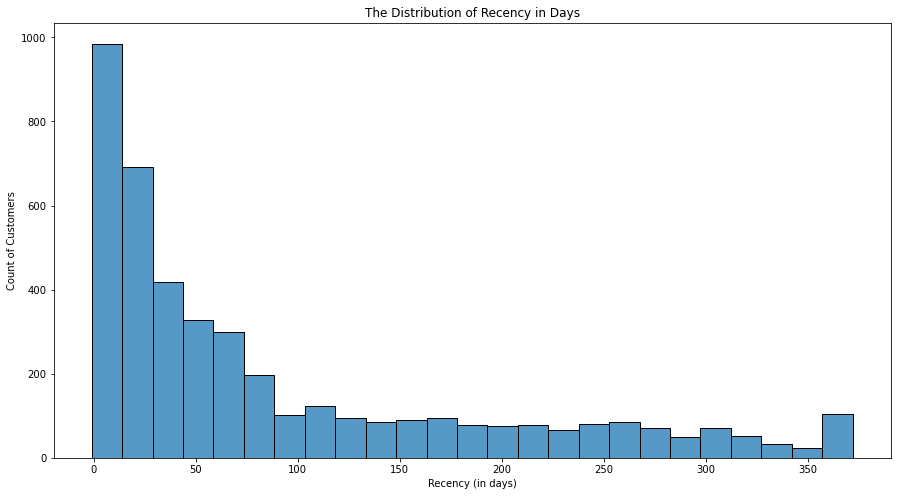

In [14]:
temp_df = (datetime(2011,12,9) - df.groupby("CustomerID").agg({"InvoiceDate":"max"}))
temp_df.rename(columns={"InvoiceDate": "Recency"}, inplace = True)
temp_df["Recency"]=temp_df["Recency"].dt.days

fig, ax=plt.subplots(figsize=(15,8))
ax=sns.histplot(x='Recency', data=temp_df, linewidth=1)
ax.set_xlabel('Recency (in days)')
ax.set_ylabel('Count of Customers')
ax.set_title('The Distribution of Recency in Days')

Text(0.5, 0, 'Sales Amount (in sterling)')

Text(0, 0.5, 'Count of Customers')

Text(0.5, 1.0, 'The Distribution of Sales Amount per Customer')

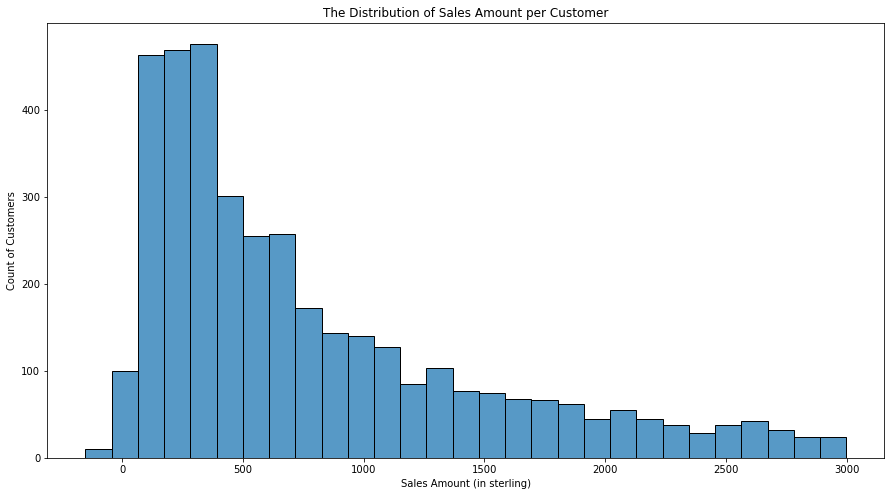

In [12]:
monetary_df = df.groupby("CustomerID").agg({"SalesAmount":"sum"})
fig, ax=plt.subplots(figsize=(15,8))
ax=sns.histplot(x='SalesAmount', data=monetary_df[(monetary_df['SalesAmount']<=3e3)&(monetary_df['SalesAmount']>=-200)], linewidth=1)
ax.set_xlabel('Sales Amount (in sterling)')
ax.set_ylabel('Count of Customers')
ax.set_title('The Distribution of Sales Amount per Customer')

<AxesSubplot:xlabel='Quantity', ylabel='Description'>

Text(0.5, 0, 'Quantity')

Text(0, 0.5, 'Description')

Text(0.5, 1.0, 'Top 20 Products by Quantity')

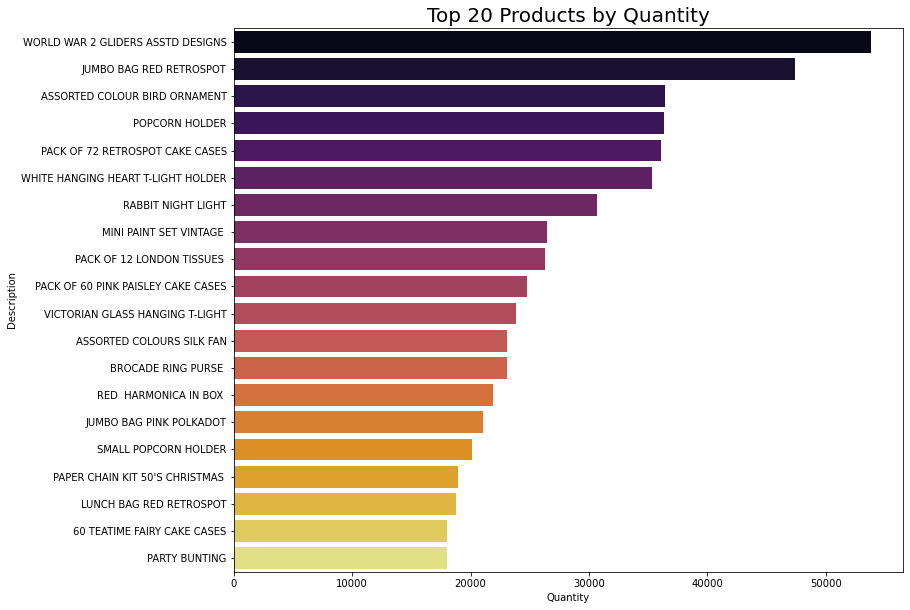

In [16]:
plt.rcParams['figure.figsize'] = (12, 10)
a = df.groupby(['Description']).agg({"Quantity":"sum"}).sort_values("Quantity", ascending = False).head(20)
sns.barplot(x =a['Quantity'], y = a.index, palette = 'inferno')
plt.xlabel('Quantity')
plt.ylabel('Description')
plt.title('Top 20 Products by Quantity', fontsize = 20)
plt.show()

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Most Frequent Words in Product Description')

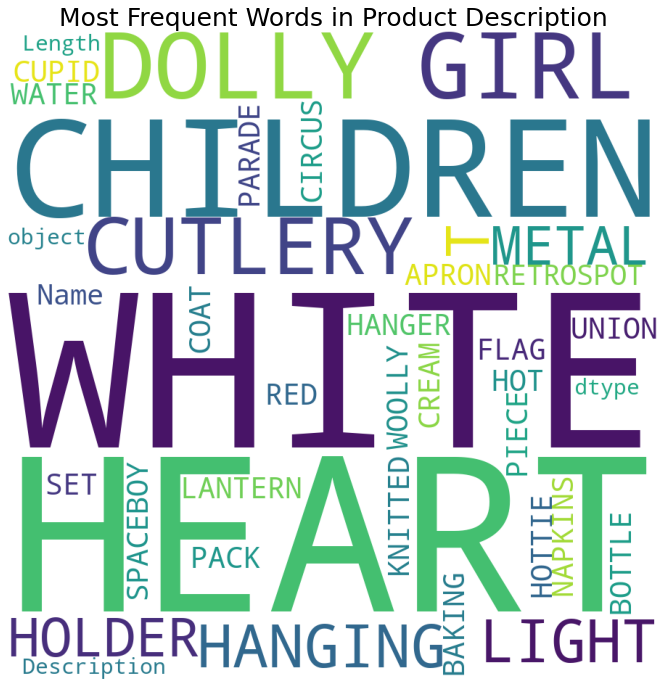

In [17]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white', width = 900, height = 900).generate(str(df['Description']))
plt.rcParams['figure.figsize'] = (12, 12)
plt.axis('off')
plt.imshow(wordcloud)
plt.title('Most Frequent Words in Product Description', fontsize = 25)
plt.show()


## Aggreate transactional data to customer level

As the transactional data is at customer id and datetime level, to build predictive model at customer level, we need aggregate data to customer level. The following aggregate function aggregates data with a speficified time frame. 


In [5]:
def aggregate_transactions(
      transactions
    , customerid_col='CustomerID'
    , datetime_col='InvoiceDate'
    , period_beg=None
    , period_end=None
    , datetime_format=None
    , freq="D"
    , freq_multiplier=1
    , include_first_transaction=True
    , monetaryvalue_col='SalesAmount'
    , quantity_col      ='Quantity'
    , item_col          ='StockCode'
):
    """
    Return customer level summary data from transactions.

    Parameters
    ----------
    transactions: :obj: DataFrame
        a Pandas DataFrame that contains the customerid_col and the datetime_col.
    customerid_col: string
        the column in transactions DataFrame that denotes the customer_id
    datetime_col:  string
        the column in transactions that denotes the datetime the purchase was made.
    period_end: datetime, optional
         a string or datetime to denote the final date of the study.
         Events after this date are truncated. If not given, defaults to the max 'datetime_col'.
    datetime_format: string, optional
        a string that represents the timestamp format. Useful if Pandas can't understand
        the provided format.
    freq: string, optional
        Default: 'D' for days. Possible values listed here:
        https://numpy.org/devdocs/reference/arrays.datetime.html#datetime-units
    freq_multiplier: int, optional
        Default: 1. Useful for getting exact recency & T. Example:
        With freq='D' and freq_multiplier=1, we get recency=591 and T=632
        With freq='h' and freq_multiplier=24, we get recency=590.125 and T=631.375
    include_first_transaction: bool, optional
        Default: False
        By default the first transaction is not included while calculating frequency and
        monetary_value. Can be set to True to include it.
        Should be False if you are going to use this data with any fitters in lifetimes package
    monetaryvalue_col: string, optional
        the columns in the transactions that denotes the monetary value of the transaction.
    quantity_col: int, optional
        the columns in the transactions that denotes the quantity of items of the transaction.
    item_col: int, optional
        the columns in the transactions that denotes the items of the transaction.
    Returns
    -------
    :obj: DataFrame:
        customer_id, min_date, max_date, Frequency, Recency, Tenure [, Monetary, Items, UniqueItems, Monetary_AOV, Items_AOV, UniqueItems_AOV]
    """
    
    if period_beg is None:
        period_beg = transactions[datetime_col].min()

    if type(period_beg) == pd.Period:
        period_beg = period_end.to_timestamp()


    if period_end is None:
        period_end = transactions[datetime_col].max()

    if type(period_end) == pd.Period:
        period_end = period_end.to_timestamp()

    select_columns = [customerid_col, datetime_col]

    extra_columns=[]

    if monetaryvalue_col:
        transactions=transactions.rename(columns={monetaryvalue_col:'Monetary'})
        monetaryvalue_col='Monetary'
        extra_columns.append(monetaryvalue_col)

    if quantity_col:
        transactions=transactions.rename(columns={quantity_col:'Items'})
        quantity_col='Items'
        extra_columns.append(quantity_col)

    if item_col:
        transactions=transactions.rename(columns={item_col:'UniqueItems'})
        item_col='UniqueItems'
        extra_columns.append(item_col)

    select_columns+=extra_columns

    transactions = transactions[select_columns].sort_values(select_columns).copy()


    # make sure the date column uses datetime objects, and use Pandas DateTimeIndex.to_period()
    # to convert the column to a PeriodIndex which is useful for time-wise grouping and truncating
    transactions[datetime_col] = pd.to_datetime(transactions[datetime_col], format=datetime_format)
    period_end = pd.to_datetime(period_end, format=datetime_format)
    period_beg = pd.to_datetime(period_beg, format=datetime_format)


    def to_period(d):
        return d.to_period(freq)

    transactions = transactions.loc[
        (transactions[datetime_col] >= period_beg)&(transactions[datetime_col] <=period_end  )
    ]


    transactions[datetime_col] = transactions[datetime_col].map(to_period)

    period_groupby = transactions.groupby([datetime_col, customerid_col], sort=False, as_index=False)

    if extra_columns:
        # when we have a monetary column, make sure to sum together any values in the same period
        customer_period = period_groupby[extra_columns].sum()
    else:
        # by calling head() on the groupby object, the datetime_col and customerid_col columns
        # will be reduced
        customer_period = period_groupby.head(1)

    if item_col:
        # when we have a monetary column, make sure to sum together any values in the same period
        customer_period[item_col] = period_groupby[item_col].nunique()


    # initialize a new column where we will indicate which are the first transactions
    customer_period["first_ind"] = 0
    # find all of the initial transactions and store as an index
    first_transactions = customer_period.groupby(customerid_col, sort=True, as_index=False).head(1).index
    # mark the initial transactions as True
    customer_period.loc[first_transactions, "first_ind"] = 1
    select_columns.append("first_ind")
    # reset datetime_col to period
    #customer_period[datetime_col] = pd.Index(customer_period[datetime_col]).to_period(freq)


    # reset datetime_col to timestamp
    customer_period[datetime_col] = pd.Index(customer_period[datetime_col]).to_timestamp()

    # count all orders by customer.
    customers = customer_period.groupby(customerid_col, sort=False)[datetime_col].agg(["min", "max", "count"])

    if not include_first_transaction:
        # subtract 1 from count, as we ignore their first order.
        customers["Frequency"] = customers["count"] - 1
    else:
        customers["Frequency"] = customers["count"]

    customers["Recency"] = (period_end - customers["max"]) / np.timedelta64(1, freq) / freq_multiplier
    customers["Tenure"]  = (period_end - customers["min"]) / np.timedelta64(1, freq) / freq_multiplier

    customers.rename(columns={'min':'min_date'}, inplace=True)
    customers.rename(columns={'max':'max_date'}, inplace=True)
    customers.drop(columns='count', inplace=True)

    if extra_columns:
        if not include_first_transaction:
            # create an index of all the first purchases
            first_purchases = customer_period[customer_period["first_ind"]==1].index
            # by setting the monetaryvalue cells of all the first purchases to NaN,
            # those values will be excluded from the mean value calculation
            customer_period.loc[first_purchases, extra_columns] = np.nan
        customers[extra_columns] = (
            customer_period.groupby(customerid_col)[extra_columns].sum().fillna(0)
    )
    AOV_columns=[x+'_AOV' for x in extra_columns]     
    customers[AOV_columns] = (
        customer_period.groupby(customerid_col)[extra_columns].mean().fillna(0)
    )

    customers.reset_index(inplace=True)

    return customers


In [6]:
pre_beg_date=df['InvoiceDate'].min()
pre_end_date=df['InvoiceDate'].max() -timedelta(days=60)

customers_pre=aggregate_transactions(
      transactions=df
    , customerid_col='CustomerID'
    , datetime_col='InvoiceDate'
    , period_beg=pre_beg_date
    , period_end=pre_end_date
    , datetime_format=None
    , freq="D"
    , freq_multiplier=1
    , include_first_transaction=True
    , monetaryvalue_col ='SalesAmount'
    , quantity_col      ='Quantity'
    , item_col          ='StockCode'
)

pst_beg_date=df['InvoiceDate'].max() -timedelta(days=59)
pst_end_date=df['InvoiceDate'].max() 


customers_pst=aggregate_transactions(
      transactions=df
    , customerid_col='CustomerID'
    , datetime_col='InvoiceDate'
    , period_beg=pst_beg_date
    , period_end=pst_end_date
    , datetime_format=None
    , freq="D"
    , freq_multiplier=1
    , include_first_transaction=True
    , monetaryvalue_col ='SalesAmount'
    , quantity_col      ='Quantity'
    , item_col          ='StockCode'
)
customers_pre.describe().T
customers_pst.describe().T
customers_pre['Monetary'].sum()
customers_pst['Monetary'].sum()



,count,mean,std,min,25%,50%,75%,max
CustomerID,"3,771.00","15,276.70","1,722.27","12,346.00","13,779.00","15,256.00","16,755.50","18,287.00"
Frequency,"3,771.00",3.83,5.60,1.00,1.00,2.00,4.00,108.00
Recency,"3,771.00",93.22,89.75,0.53,18.53,59.53,151.53,313.53
Tenure,"3,771.00",196.47,96.85,0.53,124.53,215.53,291.53,313.53
Monetary,"3,771.00","1,635.62","6,880.81","-4,287.63",266.20,581.83,"1,404.51","203,231.19"
Items,"3,771.00",965.71,"3,906.88",-303.00,134.00,327.00,799.00,"144,056.00"
UniqueItems,"3,771.00",74.02,161.15,1.00,15.00,35.00,82.00,"5,078.00"
Monetary_AOV,"3,771.00",349.34,470.74,"-4,287.63",157.11,253.40,392.63,"10,767.95"
Items_AOV,"3,771.00",211.72,315.91,-244.00,78.00,141.43,251.00,"7,824.00"
UniqueItems_AOV,"3,771.00",19.99,18.11,1.00,8.33,15.00,26.00,219.00


,count,mean,std,min,25%,50%,75%,max
CustomerID,"2,412.00","15,305.09","1,719.45","12,347.00","13,845.50","15,296.50","16,811.50","18,287.00"
Frequency,"2,412.00",1.98,1.91,1.00,1.00,1.00,2.00,38.00
Recency,"2,412.00",22.19,16.59,0.53,8.53,18.53,33.53,59.53
Tenure,"2,412.00",34.72,15.97,0.53,22.53,36.53,49.53,59.53
Monetary,"2,412.00",869.83,"2,770.83","-1,579.51",214.31,405.00,799.60,"76,257.83"
Items,"2,412.00",515.57,"1,583.92","-1,228.00",118.00,244.00,503.25,"52,663.00"
UniqueItems,"2,412.00",46.09,113.84,1.00,12.00,26.00,53.00,"3,580.00"
Monetary_AOV,"2,412.00",384.40,570.44,"-1,579.51",164.08,276.44,429.02,"12,393.70"
Items_AOV,"2,412.00",237.78,403.69,"-1,228.00",89.38,160.00,280.50,"12,540.00"
UniqueItems_AOV,"2,412.00",23.51,23.83,1.00,8.50,16.34,31.00,397.78


6167908.574000001

2098022.33



## Combine Pre and Post Data

Combine pre and post data into one dataset. The pre dataset contains features in the prediction window and post datasets constains target variable. 

In [7]:
customers = customers_pre.merge(customers_pst, how="left", on='CustomerID', suffixes=('_pre', '_pst'))
customers.fillna(0, inplace=True)

customers['buyind_pst']=np.where(customers['Frequency_pst']==0, 0, 1)


customers.describe().T
customers.head()
customers.info()
customers.index
customers.columns

,count,mean,std,min,25%,50%,75%,max
CustomerID,"3,771.00","15,276.70","1,722.27","12,346.00","13,779.00","15,256.00","16,755.50","18,287.00"
Frequency_pre,"3,771.00",3.83,5.60,1.00,1.00,2.00,4.00,108.00
Recency_pre,"3,771.00",93.22,89.75,0.53,18.53,59.53,151.53,313.53
Tenure_pre,"3,771.00",196.47,96.85,0.53,124.53,215.53,291.53,313.53
Monetary_pre,"3,771.00","1,635.62","6,880.81","-4,287.63",266.20,581.83,"1,404.51","203,231.19"
Items_pre,"3,771.00",965.71,"3,906.88",-303.00,134.00,327.00,799.00,"144,056.00"
UniqueItems_pre,"3,771.00",74.02,161.15,1.00,15.00,35.00,82.00,"5,078.00"
Monetary_AOV_pre,"3,771.00",349.34,470.74,"-4,287.63",157.11,253.40,392.63,"10,767.95"
Items_AOV_pre,"3,771.00",211.72,315.91,-244.00,78.00,141.43,251.00,"7,824.00"
UniqueItems_AOV_pre,"3,771.00",19.99,18.11,1.00,8.33,15.00,26.00,219.00


,CustomerID,min_date_pre,max_date_pre,Frequency_pre,Recency_pre,Tenure_pre,Monetary_pre,Items_pre,UniqueItems_pre,Monetary_AOV_pre,Items_AOV_pre,UniqueItems_AOV_pre,min_date_pst,max_date_pst,Frequency_pst,Recency_pst,Tenure_pst,Monetary_pst,Items_pst,UniqueItems_pst,Monetary_AOV_pst,Items_AOV_pst,UniqueItems_AOV_pst,buyind_pst
0,"12,346.00",2011-01-18,2011-01-18,1,265.53,265.53,0.00,0,1,0.00,0.00,1.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
1,"12,347.00",2010-12-07,2011-08-02,5,69.53,307.53,"2,790.86",1590,124,558.17,318.00,24.80,2011-10-31 00:00:00,2011-12-07 00:00:00,2.00,2.53,39.53,"1,519.14",868.00,58.00,759.57,434.00,29.00,1
2,"12,348.00",2010-12-16,2011-09-25,4,15.53,298.53,"1,797.24",2341,27,449.31,585.25,6.75,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
3,"12,350.00",2011-02-02,2011-02-02,1,250.53,250.53,334.40,197,17,334.40,197.00,17.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
4,"12,352.00",2011-02-16,2011-09-28,6,12.53,236.53,"1,233.68",343,68,205.61,57.17,11.33,2011-11-03 00:00:00,2011-11-03 00:00:00,1.00,36.53,36.53,311.73,127.00,15.00,311.73,127.00,15.00,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3771 entries, 0 to 3770
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           3771 non-null   float64       
 1   min_date_pre         3771 non-null   datetime64[ns]
 2   max_date_pre         3771 non-null   datetime64[ns]
 3   Frequency_pre        3771 non-null   int64         
 4   Recency_pre          3771 non-null   float64       
 5   Tenure_pre           3771 non-null   float64       
 6   Monetary_pre         3771 non-null   float64       
 7   Items_pre            3771 non-null   int64         
 8   UniqueItems_pre      3771 non-null   int64         
 9   Monetary_AOV_pre     3771 non-null   float64       
 10  Items_AOV_pre        3771 non-null   float64       
 11  UniqueItems_AOV_pre  3771 non-null   float64       
 12  min_date_pst         3771 non-null   object        
 13  max_date_pst         3771 non-nul

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770],
           dtype='int64', length=3771)

Index(['CustomerID', 'min_date_pre', 'max_date_pre', 'Frequency_pre', 'Recency_pre', 'Tenure_pre', 'Monetary_pre', 'Items_pre', 'UniqueItems_pre',
       'Monetary_AOV_pre', 'Items_AOV_pre', 'UniqueItems_AOV_pre', 'min_date_pst', 'max_date_pst', 'Frequency_pst', 'Recency_pst', 'Tenure_pst',
       'Monetary_pst', 'Items_pst', 'UniqueItems_pst', 'Monetary_AOV_pst', 'Items_AOV_pst', 'UniqueItems_AOV_pst', 'buyind_pst'],
      dtype='object')

# Opportunity I: RFM Segmentation and Trigger Process

## K-Means Clustering

Aggregate data at customer level, calculate Recency, Frequency and Monetary value.
Standize metrics so that metrics are in the same scale
Use Elbow method to estimate the optimal number of clusters, k


StandardScaler()

KMeans(n_clusters=1, random_state=0)

KMeans(n_clusters=2, random_state=0)

KMeans(n_clusters=3, random_state=0)

KMeans(n_clusters=4, random_state=0)

KMeans(n_clusters=5, random_state=0)

KMeans(n_clusters=6, random_state=0)

KMeans(n_clusters=7, random_state=0)

KMeans(random_state=0)

KMeans(n_clusters=9, random_state=0)

KMeans(n_clusters=10, random_state=0)

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'Distortion')

Text(0.5, 1.0, 'Determine the optimal number of clusters in K-Means')

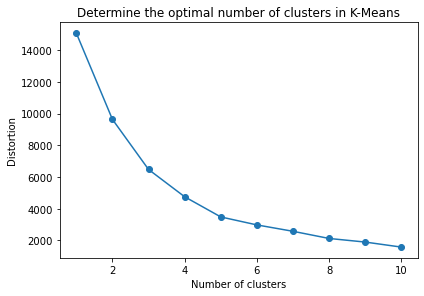

In [8]:
feature_cols = ['Frequency_pre', 'Recency_pre', 'Monetary_pre', 'Items_pre']
X = customers.loc[:, feature_cols]
feature_cols_pst = [x.replace('_pre', '_pst') for x in feature_cols]
X_pst = customers.loc[:, feature_cols_pst]

#scaler = RobustScaler()
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_pst = scaler.transform(X_pst)

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.title('Determine the optimal number of clusters in K-Means')
plt.show()

In [16]:
#build and train model
n_clusters = 5
km = KMeans(n_clusters=n_clusters, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
km = km.fit(X)
customers['label']  =km.predict(X)+1

#cluster mean value for each feature
a1=customers[feature_cols[1:2]+['label']].groupby('label').count()
a1.columns=['Count']
a2=customers[feature_cols   +['label']].groupby('label').mean()
a=a1.join(a2)
a['Segment']='At Risk'
a.loc[a.index==1, 'Segment']='At Risk'
a.loc[a.index==2, 'Segment']='Lapsed'
a.loc[a.index==3, 'Segment']='Champions'
a.loc[a.index==4, 'Segment']='Promising'
a.loc[a.index==5, 'Segment']='Loyal Customers'
a

,Count,Frequency_pre,Recency_pre,Monetary_pre,Items_pre,Segment
label,,,,,,
1,2338,3.24,44.63,"1,060.61",650.96,At Risk
2,1142,1.57,212.45,442.55,244.19,Lapsed
3,4,24.25,6.78,"168,778.23","80,929.75",Champions
4,270,15.31,16.58,"6,324.05","3,676.86",Promising
5,17,49.82,3.30,"47,071.29","30,847.94",Loyal Customers


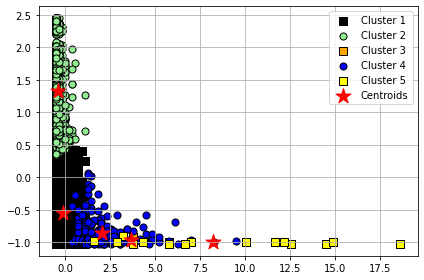

In [73]:
km = KMeans(n_clusters=5,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km= km.fit_predict(X)+1


clusters=[1,2,3,4,5]
markers=['s', 'o', 's', 'o', 's']
colors = ['black', 'lightgreen', 'orange', 'blue', 'yellow']
labels=['Cluster '+str(i) for i in clusters]

for i, color, marker, label in zip(clusters, colors, markers, labels):    
    plt.scatter(X[y_km == i, 0],
                X[y_km == i, 1],
                s=50,
                color=color,
                edgecolor='black',
                marker=marker,
                label=label);
         
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='Centroids')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Trigger Process

The objective is to forecast customer buying cycle and send reminding message prior to next purchase date.
Calculate customer average number of days between two consecutive purchases during last 12 months. If this average number falls in the window of recency plus/minus seven days, this is a trigger and send the reminding message



In [91]:
#Focus only on customers with mulitple (>=2) purchases 
trigger_df=customers[customers['Frequency_pre']>=2].copy()
a1=(trigger_df['max_date_pre']-trigger_df['min_date_pre'])/np.timedelta64(1,'D')/(trigger_df['Frequency_pre']-1)
trigger_df['Latency_pre']=a1-trigger_df['Recency_pre']
trigger_df['trigger_ind']=np.where(abs(trigger_df['Latency_pre'])<=7, 'Trigger', 'No-Trigger')
trigger_df['trigger_ind'].value_counts(normalize=True)

No-Trigger   0.89
Trigger      0.11
Name: trigger_ind, dtype: float64

# Opportunity II: Propensity Modelling

## Prepare Training and Test Data

Split dataset into separate training and test datasets, where we will use the former to fit the model and the latter to evaluate its performance. Also we do a feature scaling to standardize our features. Standardization will make it easier for us to check and compare the coefficeints in the model and in some way imdicates the variable importance. 


In [17]:
feature_cols = ['Frequency_pre', 'Recency_pre', 'Tenure_pre', 'Monetary_pre', 'Items_pre', 'UniqueItems_pre']
target_col='buyind_pst'
X, y = customers.loc[:, feature_cols], customers.loc[:, target_col]

X=X.reset_index(drop=True)
y=y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


#scaler = RobustScaler()
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

StandardScaler()

## Model Fitting and Performance measure

In [18]:
clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = KNeighborsClassifier(n_neighbors=5,
                            p=2,
                            metric='minkowski')

clf3 = DecisionTreeClassifier(max_depth=3,
                              criterion='entropy',
                              random_state=0)

clf4 = RandomForestClassifier(max_depth=3,
                              criterion='entropy',
                              random_state=0)

clf5 = XGBClassifier(base_score=0.5, booster='gbtree', 
                     learning_rate=0.1, gamma=0,  max_depth=3, reg_alpha=0, reg_lambda=1,
                     n_estimators=100, n_jobs=1, objective='binary:logistic')

all_clf=[clf1, clf2, clf3, clf4, clf5]
clf_labels = ['Logistic Regression', 'KNN', 'Decision tree', 'Random Forest', 'XGBoost']

print('10-fold cross validation:\n')
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"% (scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.74 (+/- 0.03) [Logistic Regression]
ROC AUC: 0.68 (+/- 0.03) [KNN]
ROC AUC: 0.72 (+/- 0.03) [Decision tree]
ROC AUC: 0.74 (+/- 0.04) [Random Forest]
ROC AUC: 0.74 (+/- 0.03) [XGBoost]


(-0.1, 1.1)

(-0.1, 1.1)

Text(0.5, 0, 'Sensitivity (FPR)')

Text(0, 0.5, '1-Specificity (TPR)')

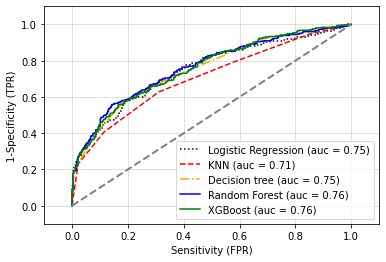

In [19]:

colors = ['black', 'red', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-', '-']
for clf, label, clr, ls    in zip(all_clf,  clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Sensitivity (FPR)')
plt.ylabel('1-Specificity (TPR)')

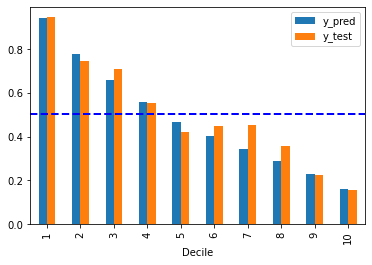

In [50]:
Decile=10-pd.qcut(y_pred,10, labels=False)
a=pd.DataFrame({'y_pred': y_pred, 'y_test':y_test, 'Decile':Decile})
b=a.groupby(['Decile']).mean()
ax=b.plot(kind='bar')
ax.axhline(y=b['y_test'].mean(), xmin=-0, xmax=1, color='blue', linestyle='--', lw=2)

## Best Model and Feature Importance
We can see both Randmo Forest model and XGBoost model performs very well and similarly. We will choose XGBoost as our best model because its performance is more stabe across training and test datasets and less overfitting. 

The feature importance plot shows the most important drivers, which could be further analyzed in marketing campaigns.

<BarContainer object of 6 artists>

([<matplotlib.axis.YTick at 0x26204900b20>,
 [Text(0, 0.5, 'Tenure_pre'),
  Text(0, 1.5, 'Items_pre'),
  Text(0, 2.5, 'Recency_pre'),
  Text(0, 3.5, 'Monetary_pre'),
  Text(0, 4.5, 'Frequency_pre'),
  Text(0, 5.5, 'UniqueItems_pre')])

Text(0.5, 1.0, 'Feature Importance ')

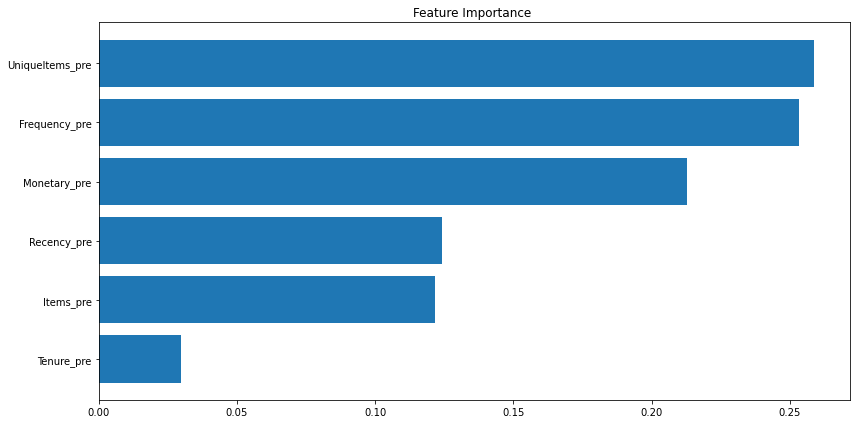

In [25]:
feature_importance = clf4.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_cols)[sorted_idx])
plt.title("Feature Importance ")
fig.tight_layout()
plt.show()

<BarContainer object of 6 artists>

([<matplotlib.axis.YTick at 0x26208b4c850>,
 [Text(0, 0.5, 'Items_pre'),
  Text(0, 1.5, 'Tenure_pre'),
  Text(0, 2.5, 'Monetary_pre'),
  Text(0, 3.5, 'Recency_pre'),
  Text(0, 4.5, 'UniqueItems_pre'),
  Text(0, 5.5, 'Frequency_pre')])

Text(0.5, 1.0, 'Feature Importance ')

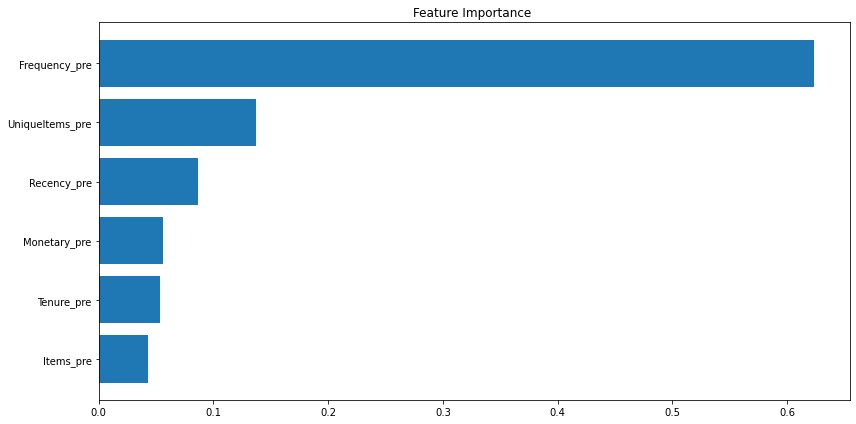

In [40]:
feature_importance = clf5.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_cols)[sorted_idx])
plt.title("Feature Importance ")
fig.tight_layout()
plt.show()

# Opportunity III: CLV Modeling

## CLV Purchase Model

Customer Lifetime Value (CLV) is a metric that captures the profit a customer would generate over a future time window. CLV purchase model predicts the expected number of transactions in the forecast window.


In [92]:
import lifetimes
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_frequency_recency_matrix


from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

from datetime import timedelta

'''
# set the last transaction date as the end point for this historical dataset
current_date = orders_pd['InvoiceDate'].max()

# calculate the required customer metrics
metrics_pd = (
  lifetimes.utils.summary_data_from_transaction_data(
    orders_pd,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date, 
    freq='D',
    monetary_value_col='SalesAmount'  # use sales amount to determine monetary value
    )
  )

# display first few rows
metrics_pd.head(10)
metrics_pd.describe().T
'''

"\n# set the last transaction date as the end point for this historical dataset\ncurrent_date = orders_pd['InvoiceDate'].max()\n\n# calculate the required customer metrics\nmetrics_pd = (\n  lifetimes.utils.summary_data_from_transaction_data(\n    orders_pd,\n    customer_id_col='CustomerID',\n    datetime_col='InvoiceDate',\n    observation_period_end = current_date, \n    freq='D',\n    monetary_value_col='SalesAmount'  # use sales amount to determine monetary value\n    )\n  )\n\n# display first few rows\nmetrics_pd.head(10)\nmetrics_pd.describe().T\n"

In [55]:

# set the last transaction date as the end point for this historical dataset
current_date = df['InvoiceDate'].max()
holdout_days=60

# define end of calibration period
calibration_end_date = current_date - timedelta(days = holdout_days)

# calculate the required customer metrics
metrics_cal_pd = (
  lifetimes.utils.calibration_and_holdout_data(
    df,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date,
    calibration_period_end=calibration_end_date,
    freq='D',
    monetary_value_col='SalesAmount'  # use sales amount to determine monetary value   
    )
  )

# display first few rows
metrics_cal_pd.head(10)
metrics_cal_pd.describe().T

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
"12,346.00",0.00,0.00,265.00,0.00,0.00,0.00,60.00
"12,347.00",4.00,238.00,307.00,519.77,2.00,26.19,60.00
"12,348.00",3.00,283.00,298.00,301.48,0.00,0.00,60.00
"12,350.00",0.00,0.00,250.00,0.00,0.00,0.00,60.00
"12,352.00",5.00,224.00,236.00,187.44,1.00,20.78,60.00
"12,353.00",0.00,0.00,144.00,0.00,0.00,0.00,60.00
"12,354.00",0.00,0.00,172.00,0.00,0.00,0.00,60.00
"12,355.00",0.00,0.00,154.00,0.00,0.00,0.00,60.00
"12,356.00",1.00,80.00,265.00,481.46,1.00,29.17,60.00


,count,mean,std,min,25%,50%,75%,max
frequency_cal,"3,771.00",2.83,5.60,0.00,0.00,1.00,3.00,107.00
recency_cal,"3,771.00",103.26,108.49,0.00,0.00,70.00,200.50,313.00
T_cal,"3,771.00",195.94,96.85,0.00,124.00,215.00,291.00,313.00
monetary_value_cal,"3,771.00",200.43,386.86,"-1,462.50",0.00,118.13,293.76,"8,522.76"
frequency_holdout,"3,771.00",1.06,1.85,0.00,0.00,0.00,1.00,39.00
monetary_value_holdout,"3,771.00",14.87,71.69,-121.80,0.00,0.00,17.31,"2,685.00"
duration_holdout,"3,771.00",60.00,0.00,60.00,60.00,60.00,60.00,60.00


In [81]:

input_pd = metrics_cal_pd[metrics_cal_pd['frequency_cal'] > 0]

# fit a model
transaction_model = ParetoNBDFitter(penalizer_coef=0.0)
transaction_model.fit( input_pd['frequency_cal'], input_pd['recency_cal'], input_pd['T_cal'])

# get predicted frequency during holdout period
frequency_holdout_predicted = transaction_model.predict( input_pd['duration_holdout'], input_pd['frequency_cal'], input_pd['recency_cal'], input_pd['T_cal'])

# get actual frequency during holdout period
frequency_holdout_actual = input_pd['frequency_holdout']

frequency_holdout_actual.describe().T
frequency_holdout_predicted.describe().T



<lifetimes.ParetoNBDFitter: fitted with 2407 subjects, alpha: 96.27, beta: 351.58, r: 1.90, s: 0.07>

count   2,407.00
mean        1.39
std         2.13
min         0.00
25%         0.00
50%         1.00
75%         2.00
max        39.00
Name: frequency_holdout, dtype: float64

count   2,407.00
mean        1.14
std         0.96
min         0.12
25%         0.62
50%         0.89
75%         1.33
max        15.91
dtype: float64

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

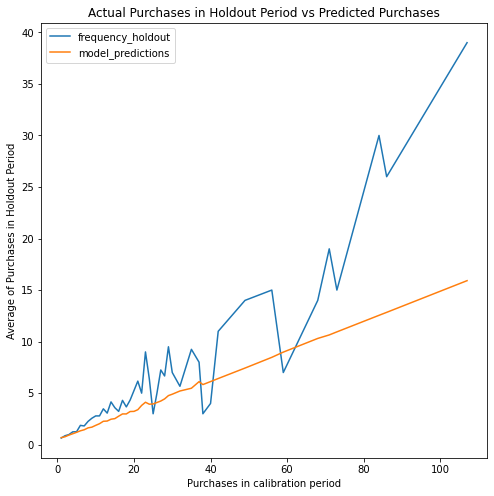

In [47]:
plot_calibration_purchases_vs_holdout_purchases(
  transaction_model, 
  input_pd, 
  n=holdout_days, 
  **{'figsize':(8,8)}
  )


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Time since user made last purchase', ylabel='Average of Purchases in Holdout Period'>

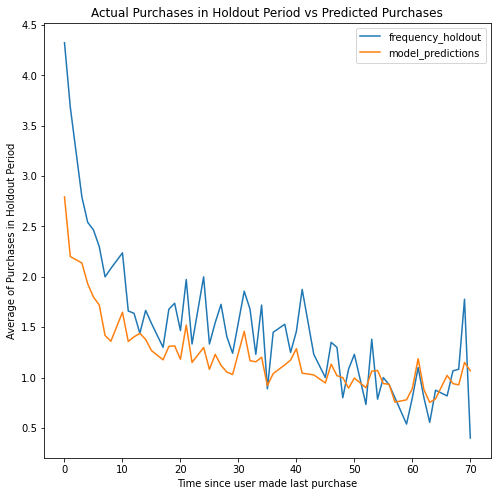

In [48]:
plot_calibration_purchases_vs_holdout_purchases(
  transaction_model, 
  input_pd, 
  kind='time_since_last_purchase', 
  n=holdout_days, 
  **{'figsize':(8,8)}
  )

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 30 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

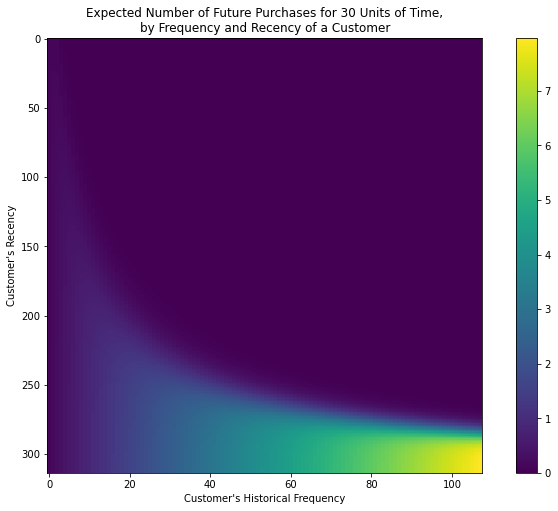

In [51]:
# set figure size
plt.subplots(figsize=(12, 8))

plot_frequency_recency_matrix(transaction_model, T=30)

In [82]:
input_pd.describe().T
input_pd.head()

,count,mean,std,min,25%,50%,75%,max
frequency_cal,"2,407.00",4.43,6.48,1.00,1.00,2.00,5.00,107.00
recency_cal,"2,407.00",161.77,94.73,1.00,84.00,169.00,245.00,313.00
T_cal,"2,407.00",225.96,80.11,3.00,180.00,245.00,301.00,313.00
monetary_value_cal,"2,407.00",314.02,445.90,"-1,462.50",133.87,234.39,373.42,"8,522.76"
frequency_holdout,"2,407.00",1.39,2.13,0.00,0.00,1.00,2.00,39.00
monetary_value_holdout,"2,407.00",18.41,68.78,-114.00,0.00,7.46,19.88,"2,232.00"
duration_holdout,"2,407.00",60.00,0.00,60.00,60.00,60.00,60.00,60.00


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
"12,347.00",4.00,238.00,307.00,519.77,2.00,26.19,60.00
"12,348.00",3.00,283.00,298.00,301.48,0.00,0.00,60.00
"12,352.00",5.00,224.00,236.00,187.44,1.00,20.78,60.00
"12,356.00",1.00,80.00,265.00,481.46,1.00,29.17,60.00
"12,359.00",3.00,142.00,271.00,970.81,2.00,25.56,60.00


## CLV Spend Model

Forcast the average spend per transaction in the foreast window

In [83]:
#instead of excluding negative monetary values, set negative monetary value to 0.01
clv_input_pd=input_pd.copy()
clv_input_pd['monetary_value_cal']=np.where(clv_input_pd['monetary_value_cal']<=0, 0.01, clv_input_pd['monetary_value_cal'])

l2_reg=0.1

spend_model = GammaGammaFitter(penalizer_coef=l2_reg)

# fit the model
spend_model.fit(clv_input_pd['frequency_cal'], clv_input_pd['monetary_value_cal'])

# evaluate the model
clv_input_pd['monetary_value_predicted']= spend_model.conditional_expected_average_profit(clv_input_pd['frequency_holdout'], clv_input_pd['monetary_value_holdout'])

actual   = clv_input_pd['monetary_value_holdout']
predicted= clv_input_pd['monetary_value_predicted']

mse = np.sum(np.square(actual -predicted))/predicted.shape[0]
mae =    np.sum(np.abs(actual -predicted))/predicted.shape[0]
print(f'MSE: {mse}')
print(f'MAE: {mae}')

<lifetimes.GammaGammaFitter: fitted with 2407 subjects, p: 0.46, q: 0.16, v: 0.71>

MSE: 140732.0365985672
MAE: 71.00294419538773


In [84]:
# calculate the 1-year CLV for each customer
clv_input_pd['clv'] = (
  spend_model.customer_lifetime_value(
    transaction_model, #the model to use to predict the number of future transactions
    clv_input_pd['frequency_cal'],
    clv_input_pd['recency_cal'],
    clv_input_pd['T_cal'],
    clv_input_pd['monetary_value_cal'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
  )
)

clv_input_pd.head(10)
clv_input_pd.describe().T

C:\Users\zhoji001\AppData\Roaming\Python\Python38\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,monetary_value_predicted,clv
CustomerID,,,,,,,,,
"12,347.00",4.00,238.00,307.00,519.77,2.00,26.19,60.00,308.34,"4,584.63"
"12,348.00",3.00,283.00,298.00,301.48,0.00,0.00,60.00,-0.39,"3,181.73"
"12,352.00",5.00,224.00,236.00,187.44,1.00,20.78,60.00,-25.96,"2,032.29"
"12,356.00",1.00,80.00,265.00,481.46,1.00,29.17,60.00,-36.10,"-1,430.30"
"12,359.00",3.00,142.00,271.00,970.81,2.00,25.56,60.00,300.95,"10,400.07"
"12,360.00",1.00,88.00,140.00,534.70,1.00,19.33,60.00,-24.21,"-2,595.07"
"12,362.00",6.00,223.00,235.00,345.91,6.00,20.97,60.00,30.32,"3,927.48"
"12,363.00",1.00,133.00,182.00,252.90,0.00,0.00,60.00,-0.39,"-1,047.82"
"12,364.00",1.00,34.00,52.00,79.80,2.00,12.44,60.00,148.57,-624.40


,count,mean,std,min,25%,50%,75%,max
frequency_cal,"2,407.00",4.43,6.48,1.00,1.00,2.00,5.00,107.00
recency_cal,"2,407.00",161.77,94.73,1.00,84.00,169.00,245.00,313.00
T_cal,"2,407.00",225.96,80.11,3.00,180.00,245.00,301.00,313.00
monetary_value_cal,"2,407.00",318.75,439.81,0.00,133.87,234.39,373.42,"8,522.76"
frequency_holdout,"2,407.00",1.39,2.13,0.00,0.00,1.00,2.00,39.00
monetary_value_holdout,"2,407.00",18.41,68.78,-114.00,0.00,7.46,19.88,"2,232.00"
duration_holdout,"2,407.00",60.00,0.00,60.00,60.00,60.00,60.00,60.00
monetary_value_predicted,"2,407.00",53.88,392.79,"-2,697.15",-4.85,-0.39,39.41,"16,901.54"
clv,"2,407.00","5,038.44","11,598.03","-14,711.29",-6.72,"2,370.89","5,602.54","192,085.81"


In [ ]:
clv_input_pd['Decile']=10-pd.qcut(clv_input_pd['clv'],10, labels=False)
b=clv_input_pd.groupby(['Decile'])['clv'].mean()
ax=b.plot(kind='bar')
ax.axhline(y=b['clv'].mean(), xmin=-0, xmax=1, color='blue', linestyle='--', lw=2)

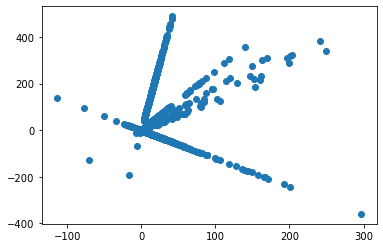

In [91]:
idx=(actual<=500)&(predicted<=500)
plt.scatter(actual[idx], predicted[idx])

# Opportunity IV: Product Recommender System

## Similarity Matrix 

The main focus is to construct an item-item based similarity matrix to project actual purchased item to recommended items. Due to computational complexity, we extract the first three digts from product code (we call it class) to build the matrix.

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [52]:
def construct_user_item(
    transactions
    , customerid_col  ='CustomerID'
    , item_col        ='StockClass'
    , quantity_col    = None
):
    if quantity_col is None:
        quantity_col    ='Quantity'    
        transactions[quantity_col]=1
        
    user_item = transactions.groupby([customerid_col, item_col ])[quantity_col].sum().unstack(fill_value=0)

    #normalize row vector by squared root of sum of squares
    scale = np.sqrt(np.square(user_item).sum(axis=1))/1000+1e-4

    user_item= user_item.div(scale, axis='index')
    
    return user_item



user_item=construct_user_item(
    df
    ,customerid_col   ='CustomerID'
    , item_col        ='StockClass'
    , quantity_col    ='Quantity'
)

user_item.head()
user_item.shape


StockClass,231,160,170,206,207,209,210,211,212,215,216,217,218,219,221,222,223,224,225,226,227,228,229,230,232,233,234,235,475,510,714,845,846,849,851,852,POS,214,220,359,374,375,481,840,850,790,791,213,M,728,843,844,150,355,727,848,352,824,826,162,820,161,180,208,793,467,825,847,700,354,842,841,460,358,725,722,710,373,900,901,473,350,356,101,110,100,400,236,620,442,171,721,723,750,C2,237,780,474,902,712,711,819,461,751,794,781,D,771,470,720,BAN,440,PAD,CRU,DOT,715,770,238,450
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"12,346.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"12,347.00",192.13,41.17,61.76,10.29,99.50,17.15,82.34,37.74,41.17,10.29,20.59,205.86,20.59,164.68,236.73,30.88,164.68,365.39,34.31,102.93,288.20,41.17,61.76,555.81,54.89,102.93,102.93,168.12,72.05,20.59,20.59,257.32,123.51,298.49,102.93,5.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"12,348.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,182.20,0.00,0.00,60.73,0.00,850.26,0.00,0.00,0.00,16.87,0.00,60.73,0.00,0.00,182.20,391.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,222.69,0.00,0.00,7.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"12,349.00",120.05,0.00,0.00,37.91,0.00,37.91,75.82,101.09,454.93,170.60,0.00,151.64,0.00,0.00,113.73,0.00,88.46,82.14,454.93,139.01,202.19,12.64,37.91,6.32,467.56,0.00,246.42,195.87,75.82,0.00,0.00,0.00,0.00,75.82,0.00,0.00,6.32,18.96,227.46,75.82,75.82,75.82,75.82,6.32,75.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"12,350.00",0.00,0.00,0.00,364.89,0.00,0.00,0.00,182.44,0.00,0.00,0.00,0.00,547.33,364.89,0.00,0.00,364.89,182.44,364.89,182.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.20,0.00,0.00,0.00,0.00,0.00,0.00,91.22,0.00,152.04,182.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


(4372, 119)

In [55]:
def calculate_similarity(user_item):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a square similaritiy matrix.
    """
    user_sparse = sparse.csr_matrix(user_item)
    similarities = cosine_similarity(user_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index= user_item.columns, columns= user_item.columns)
    return sim

from sklearn.utils import shuffle
#Split into train and test data
X = shuffle(user_item, random_state=13)
offset = int(X.shape[0] * 0.6)
user_item_train, user_item_test = X.iloc[:offset,:], X.iloc[offset:,:]

similarity_item= calculate_similarity(user_item_train)


similarity_item.head()
similarity_item.shape

StockClass,231,160,170,206,207,209,210,211,212,215,216,217,218,219,221,222,223,224,225,226,227,228,229,230,232,233,234,235,475,510,714,845,846,849,851,852,POS,214,220,359,374,375,481,840,850,790,791,213,M,728,843,844,150,355,727,848,352,824,826,162,820,161,180,208,793,467,825,847,700,354,842,841,460,358,725,722,710,373,900,901,473,350,356,101,110,100,400,236,620,442,171,721,723,750,C2,237,780,474,902,712,711,819,461,751,794,781,D,771,470,720,BAN,440,PAD,CRU,DOT,715,770,238,450
StockClass,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
231,1.00,0.08,0.07,0.11,0.21,0.20,0.19,0.23,0.20,0.20,0.18,0.27,0.24,0.27,0.29,0.24,0.24,0.32,0.29,0.39,0.35,0.26,0.39,0.33,0.43,0.39,0.28,0.26,0.17,0.05,0.10,0.11,0.11,0.23,0.22,0.10,0.09,0.20,0.25,0.13,0.06,0.06,0.09,0.18,0.24,0.06,0.05,0.20,0.01,0.06,0.15,0.06,0.06,0.02,0.06,0.21,0.00,0.12,0.08,0.09,0.02,0.12,0.01,0.12,0.02,0.00,0.13,0.14,0.02,0.04,0.05,0.03,0.06,0.05,0.02,0.03,0.06,0.05,0.02,0.05,0.06,0.07,0.05,0.07,0.03,0.02,0.02,0.10,0.01,0.03,0.04,0.02,0.03,0.05,0.00,0.00,0.02,0.05,0.01,0.02,0.01,0.02,0.04,0.02,0.02,0.02,-0.03,0.01,0.06,0.00,0.01,0.03,0.00,-0.01,0.01,0.00,0.00,0.00,0.00
160,0.08,1.00,0.03,0.09,0.05,0.11,0.07,0.05,0.05,0.04,0.09,0.08,0.06,0.08,0.08,0.05,0.07,0.09,0.10,0.10,0.08,0.07,0.08,0.08,0.07,0.09,0.05,0.06,0.04,0.03,0.03,0.05,0.04,0.05,0.05,0.05,0.04,0.07,0.08,0.04,0.01,0.02,0.02,0.07,0.06,0.01,0.05,0.05,0.00,0.02,0.06,0.00,0.05,0.01,0.00,0.04,0.00,0.02,0.03,0.14,0.00,0.05,0.01,0.08,0.00,0.00,0.02,0.03,0.02,0.02,0.02,0.03,0.01,0.04,0.01,0.05,0.03,0.02,0.01,0.01,0.01,0.00,0.02,0.04,0.02,0.01,0.06,0.01,0.00,0.02,0.01,0.02,0.01,0.03,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.01,0.03,0.00,0.00,-0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
170,0.07,0.03,1.00,0.10,0.05,0.08,0.07,0.08,0.07,0.07,0.13,0.07,0.10,0.08,0.09,0.08,0.05,0.10,0.06,0.09,0.09,0.07,0.09,0.07,0.07,0.07,0.07,0.05,0.06,0.10,0.03,0.06,0.04,0.06,0.10,0.06,0.00,0.08,0.10,0.05,0.03,0.02,0.02,0.05,0.09,0.03,0.04,0.06,0.04,0.04,0.04,0.03,0.15,0.02,0.02,0.06,0.00,0.05,0.03,0.05,0.00,0.05,0.08,0.08,0.02,0.00,0.04,0.04,0.02,0.03,0.05,0.06,0.00,0.01,0.02,0.03,0.02,0.05,0.06,0.10,0.08,0.04,0.05,0.06,0.03,0.05,0.02,0.04,0.03,0.05,0.05,0.02,0.08,0.02,0.00,0.00,0.01,0.02,0.05,0.01,0.00,0.01,0.01,0.05,0.00,0.05,-0.11,0.03,0.00,0.00,0.00,0.07,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
206,0.11,0.09,0.10,1.00,0.10,0.10,0.12,0.09,0.21,0.13,0.11,0.10,0.14,0.12,0.14,0.08,0.14,0.13,0.12,0.13,0.12,0.10,0.12,0.09,0.12,0.12,0.08,0.08,0.09,0.02,0.02,0.08,0.09,0.10,0.10,0.11,0.07,0.11,0.11,0.08,0.04,0.02,0.11,0.09,0.12,0.03,0.14,0.10,0.01,0.08,0.04,0.03,0.12,0.05,0.03,0.07,0.02,0.04,0.04,0.07,0.01,0.04,0.03,0.08,0.01,0.00,0.08,0.04,0.01,0.02,0.08,0.01,0.12,0.05,0.01,0.02,0.03,0.04,0.03,0.05,0.03,0.01,0.03,0.02,0.03,0.01,0.01,0.03,0.00,0.03,0.02,0.01,0.02,0.02,0.00,0.00,0.01,0.01,0.01,0.03,0.00,0.01,0.05,0.08,0.00,0.00,-0.05,0.02,0.00,0.00,0.00,0.01,0.00,-0.01,0.01,0.00,0.00,0.00,0.05
207,0.21,0.05,0.05,0.10,1.00,0.22,0.17,0.16,0.20,0.16,0.12,0.18,0.16,0.36,0.19,0.17,0.51,0.23,0.22,0.26,0.20,0.16,0.21,0.16,0.39,0.22,0.14,0.16,0.15,0.03,0.06,0.12,0.07,0.15,0.14,0.07,0.13,0.18,0.16,0.10,0.04,0.02,0.06,0.12,0.32,0.08,0.04,0.12,0.01,0.04,0.09,0.05,0.08,0.01,0.02,0.11,0.04,0.07,0.06,0.08,0.01,0.10,0.02,0.06,0.02,0.00,0.08,0.08,0.03,0.02,0.04,0.01,0.02,0.02,0.01,0.01,0.03,0.07,0.01,0.02,0.05,0.02,0.05,0.05,0.05,0.07,0.04,0.06,0.02,0.02,0.03,0.01,0.04,0.03,0.00,0.00,0.00,0.03,0.01,0.06,0.01,0.01,0.02,0.02,0.01,0.02,-0.01,0.01,0.01,0.00,0.00,0.01,0.00,-0.01,0.01,0.00,0.00,0.00,0.00


(119, 119)

## Recommend Top N items

In [56]:
def construct_recommend(wide, similarity_item, n, customerid_col='CustomerID', type='pred'):
    """Construct top n recommendations. 
       Transform from wide to long matrix.
    """
    if type=='pred': 
        a=wide.dot(similarity_item)
    elif type=='real':
        a=wide
        
    a2=a.reset_index().melt(id_vars=customerid_col).sort_values(by=[customerid_col, 'value'], )
    long=a2.assign(
        rn=a2.sort_values([customerid_col, 'value'], ascending=(True, False))
        .groupby([customerid_col])
        .cumcount() + 1 ).query("rn <=" +str(n)).sort_values([customerid_col, 'rn'], ascending=True)
    return long




In [59]:
customerid_col  ='CustomerID'

def accuracy_score(user_item, n):
    """Calculate the accuracy score as average score of match between real purchased items and recommended items.
    """
    real=construct_recommend(user_item, similarity_item, n, customerid_col='CustomerID', type='real') 
    pred=construct_recommend(user_item, similarity_item, n, customerid_col='CustomerID', type='pred') 
    match_or_not=real.merge(pred, on=[customerid_col, 'rn'], how='inner')
    return np.mean(match_or_not['StockClass_x']==match_or_not['StockClass_y'])   

accuracy_score_train=[]
for i in range(1,11):
    accuracy_score_train.append(accuracy_score(user_item_train, i))

accuracy_score_test=[]
for i in range(1,11):
    accuracy_score_test.append(accuracy_score(user_item_test, i))
    
accuracy_score_train
accuracy_score_test

[0.7411361036980557,
 0.5928326343881052,
 0.4803659931376287,
 0.3981128478841022,
 0.34098360655737703,
 0.29495488626254923,
 0.26153259626382,
 0.23422607701105605,
 0.21269115092980895,
 0.19515821578345405]

[0.7444253859348199,
 0.5914808461978274,
 0.4671240708976558,
 0.38607775871926814,
 0.3280731846769583,
 0.28444825614636937,
 0.25173568569794985,
 0.22577186963979418,
 0.2046248650022235,
 0.18759291023441968]

<Figure size 720x576 with 0 Axes>

Text(0.5, 0, '# of Recommendations')

Text(0, 0.5, 'Accuracy Score')

Text(0.5, 1.0, 'Accuracy of Top N Recommendations')

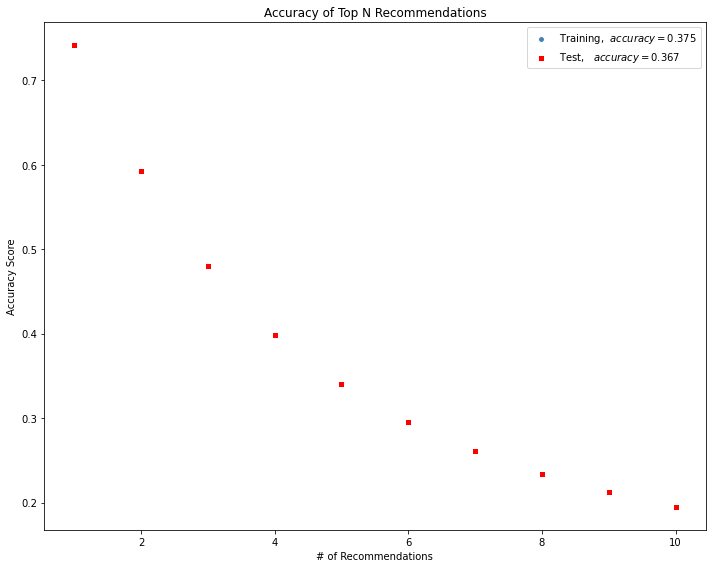

In [60]:
plt.figure(figsize=(10, 8))
plt.scatter(range(1, len(accuracy_score_train)+1), accuracy_score_train, 
                c='steelblue', marker='o', edgecolor='white',
                label=f'Training,  $accuracy={np.mean(accuracy_score_train):.3f}$')
plt.scatter(range(1, len(accuracy_score_test)+1), accuracy_score_train, 
                c='red', marker='s', edgecolor='white',
                label=f'Test,   $accuracy={np.mean(accuracy_score_test):.3f}$')
plt.xlabel('# of Recommendations')
plt.ylabel('Accuracy Score')
plt.legend(loc='upper right')
plt.title("Accuracy of Top N Recommendations")
plt.tight_layout()
plt.show()